# Inverse scattering for circular billiard

## Importação das bibliotecas

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import utils.Utils as utils
import utils.GenerateData as generateData
import model.GeneralizedMLP as gMLP

## Lendo os dados

In [2]:
df = pd.read_csv('./data/dados.csv')

In [3]:
df

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k587,l_k588,l_k589,l_k590,l_k591,l_k592,l_k593,l_k594,l_k595,l_k596
0,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.100000,0.155397,...,0.001165,0.001162,0.001160,0.001158,0.001156,0.001154,0.001151,0.001149,0.001147,0.001145
1,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.110053,0.184685,...,0.001384,0.001382,0.001379,0.001376,0.001374,0.001371,0.001368,0.001366,0.001363,0.001360
2,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.120106,0.215951,...,0.001616,0.001613,0.001610,0.001607,0.001603,0.001600,0.001597,0.001594,0.001591,0.001587
3,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.130159,0.249095,...,0.001859,0.001855,0.001851,0.001847,0.001843,0.001839,0.001836,0.001832,0.001828,0.001824
4,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.140212,0.284026,...,0.002109,0.002105,0.002100,0.002096,0.002091,0.002087,0.002082,0.002078,0.002073,0.002069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55095,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.959788,34.509730,...,9.570126,9.597571,9.622035,9.642763,9.658887,9.669430,9.673316,9.669396,9.656485,9.633432
55096,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.969841,34.602123,...,9.705567,9.723303,9.735533,9.741150,9.738963,9.727735,9.706246,9.673381,9.628239,9.570257
55097,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.979894,34.694353,...,9.808430,9.808259,9.799045,9.779501,9.748425,9.704819,9.648019,9.577836,9.494682,9.399662
55098,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.989947,34.786420,...,9.853002,9.824148,9.782554,9.727437,9.658485,9.576006,9.481020,9.375310,9.261361,9.142220


## Plot da scattering cross length para gamma, R = 2.0

In [ ]:
df_R_2 = df[df['R'] == 2.0]

In [ ]:
row_gamma_R_2 = df_R_2[(df_R_2['gamma'] > 1.97) & (df_R_2['gamma'] < 2.03)]

In [ ]:
row_gamma_R_2

In [ ]:
l_array = row_gamma_R_2.drop(columns=['M', 'HBAR', 'k_min', 'k_max', 'delta_k', 'n_min', 'n_max', 'gamma', 'R']).to_numpy()

In [ ]:
l_array.shape

In [ ]:
k_min = 0.02
k_max = 3.0
k = np.linspace(k_min, k_max, 596)

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array[0], ls='-', label=f"$\gamma = 1.97$")
axes.plot(k, l_array[1], ls='-', label=f"$\gamma = 1.98$")
axes.plot(k, l_array[2], ls='-', label=f"$\gamma = 1.99$")
axes.plot(k, l_array[3], ls='-', label=f"$\gamma = 2.00$")
axes.plot(k, l_array[4], ls='-', label=f"$\gamma = 2.01$")
axes.plot(k, l_array[5], ls='-', label=f"$\gamma = 2.02$")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

## Implementação da rede neural

### Definição dos inputs da rede

In [4]:
features = df.drop(columns=['gamma', 'R'])

features = features.to_numpy()

In [5]:
targets = df[['gamma', 'R']]

targets = targets.to_numpy()

In [6]:
print(features.shape)
print(targets.shape)

(55100, 603)
(55100, 2)


### Definição da rede neural

A rede neural implementada é uma rede neural do tipo Multilayer Perceptron

### Variáveis para o modelo, separação dos dados de teste e treino e etc

In [7]:
train, test_data = train_test_split(features, test_size = 0.2, random_state = 2)
real_train_data, validation_data = train_test_split(train, test_size = 0.3, random_state = 2)

train_target, test_target = train_test_split(targets, test_size = 0.2, random_state = 2)
real_train_target, validation_target = train_test_split(train_target, test_size = 0.3, random_state = 2)

input_size = 603
output_size = 2
batch_size = 32
num_epochs = 150
learning_rate = 0.0001

In [8]:
train_loader, val_loader, test_loader = utils.prepare_data(real_train_data, real_train_target, test_data, test_target, validation_data, validation_target, batch_size)

Input Shapes:
torch.Size([30856, 603]) torch.Size([13224, 603]) torch.Size([11020, 603])
Target Shapes:
torch.Size([30856, 2]) torch.Size([13224, 2]) torch.Size([11020, 2])


### Primeira rodada de treinamento

In [9]:
nums_neurons = [20, 40, 60, 80, 100, 140, 180, 220, 260, 300, 340, 380, 420]
running_loss_total_arrays = []
val_loss_total_arrays = []
test_loss_total = []

for num in nums_neurons:
    
    model = gMLP.GeneralizedMLP(input_size, output_size, 1, num)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train and evaluate the model
    running_loss_array, val_loss_array = gMLP.train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

    running_loss_total_arrays.append(running_loss_array)
    val_loss_total_arrays.append(val_loss_array)
    outputs, test_loss = gMLP.evaluate_model(model, criterion, test_loader)
    test_loss_total.append(test_loss)

# torch.save(model.state_dict(), 'mlp_weights.pth')

Using num_neurons =  20
Epoch 1/150, Training Loss: 0.458921603773542, Validation Loss: 0.18094161937490177
Epoch 2/150, Training Loss: 0.10747552220106434, Validation Loss: 0.06643007555301639
Epoch 3/150, Training Loss: 0.05246873914114552, Validation Loss: 0.04149570081333499
Epoch 4/150, Training Loss: 0.03704717792860121, Validation Loss: 0.03222052388428598
Epoch 5/150, Training Loss: 0.03030383756644831, Validation Loss: 0.02816948345704859
Epoch 6/150, Training Loss: 0.026664454225991212, Validation Loss: 0.024314801709204553
Epoch 7/150, Training Loss: 0.02444267172530448, Validation Loss: 0.022490310609781582
Epoch 8/150, Training Loss: 0.022924450742457195, Validation Loss: 0.02166639002836377
Epoch 9/150, Training Loss: 0.021675080401157006, Validation Loss: 0.019967780366386984
Epoch 10/150, Training Loss: 0.020663154091435085, Validation Loss: 0.019566360374030787
Epoch 11/150, Training Loss: 0.019762131380679695, Validation Loss: 0.018286333748944786
Epoch 12/150, Traini

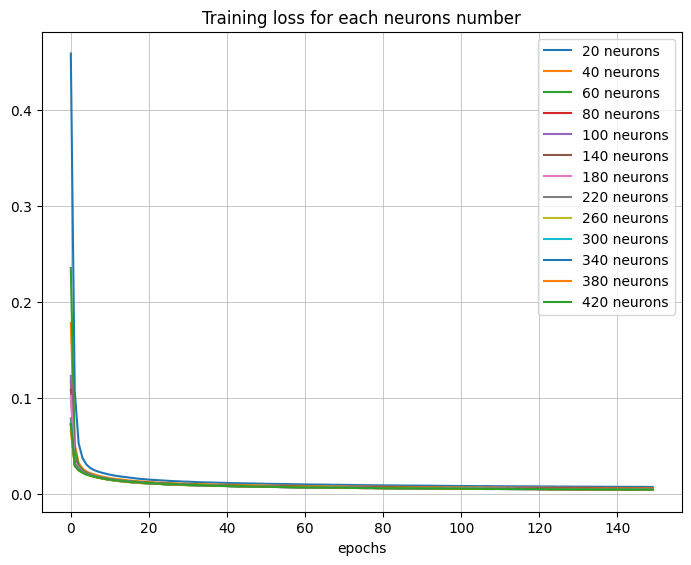

In [15]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
# plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
for running_loss in running_loss_total_arrays:
    index = running_loss_total_arrays.index(running_loss)
    num_neurons_used = nums_neurons[index]
    axes.plot(running_loss, ls='-', label=f"{num_neurons_used} neurons")

axes.set_title(f'Training loss for each neurons number')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

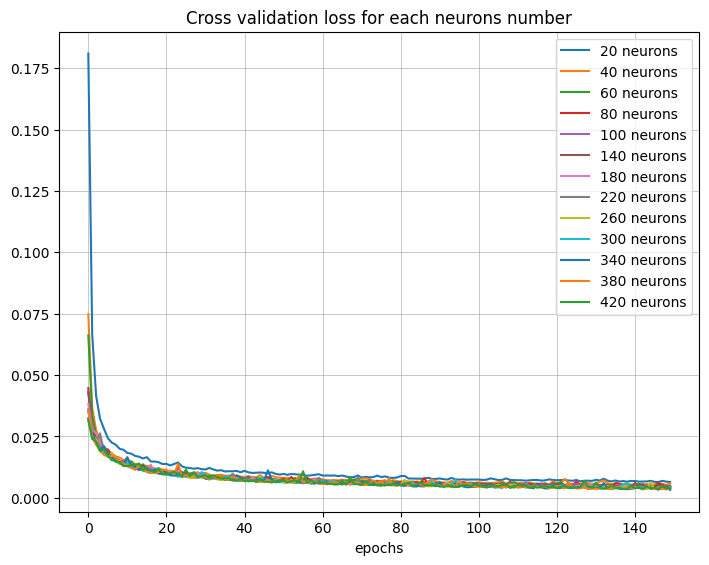

In [13]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])

for val_loss in val_loss_total_arrays:
    index = val_loss_total_arrays.index(val_loss)
    num_neurons_used = nums_neurons[index]
    axes.plot(val_loss, ls='-', label=f"{num_neurons_used} neurons")

axes.set_title(f'Cross validation loss for each neurons number')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [16]:
val_loss_total_arrays[-1]

[0.031489299234578716,
 0.023924249227739114,
 0.02291945854521352,
 0.019027042454041108,
 0.019832416292468923,
 0.01718833781092693,
 0.015311567745495426,
 0.015078334489855285,
 0.014239469642080546,
 0.012928900110382353,
 0.012951626974958837,
 0.013185568541346865,
 0.013439198899091839,
 0.013975908327397805,
 0.011200813959568632,
 0.012224817065047414,
 0.011142866039797123,
 0.010440695141712069,
 0.011739755181510199,
 0.009548042736500997,
 0.00961968285686242,
 0.010098004632669947,
 0.010561088673716438,
 0.009805995866078164,
 0.008677466474287887,
 0.011489175882635882,
 0.008831466875457461,
 0.01035771584942496,
 0.008401563199383774,
 0.008723913392463726,
 0.009118975381139701,
 0.008163619129344876,
 0.009098976845729304,
 0.008332198331355239,
 0.007786398651027728,
 0.007985099869052506,
 0.007958774289829378,
 0.007096760530917003,
 0.006925060524569222,
 0.007705954340756714,
 0.006809531912659767,
 0.006858872426454437,
 0.007172673523081871,
 0.006548098189

In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = []
list_val = []
for val_loss in val_loss_total_arrays:
    # avg = 0
    # for val in val_loss[-10:]:
    #     avg = avg + (val/20.0)
    list_val.append(val_loss[-1])

for train_loss in running_loss_total_arrays:
    # avg = 0
    # for train in train_loss[-10:]:
    #     avg = avg + (train/20.0)
    
    list_train.append(train_loss[-1])


# >>> a=axes.get_xticks().tolist()
# >>> a[1]='change'
# >>> axes.set_xticklabels(a)

axes.plot(nums_neurons, list_train, ls='-.', lw=2, label='loss of the last epoch for train data')
axes.plot(nums_neurons, list_val, ls='-.', lw=2, label='loss of the last epoch for cross-validation data')
axes.plot(nums_neurons, test_loss_total, ls='-.', lw=2, label='loss of the test data')

axes.set_title(f'Loss by number of hidden neurons')
axes.set_xlabel(f'Number of hidden neurons')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

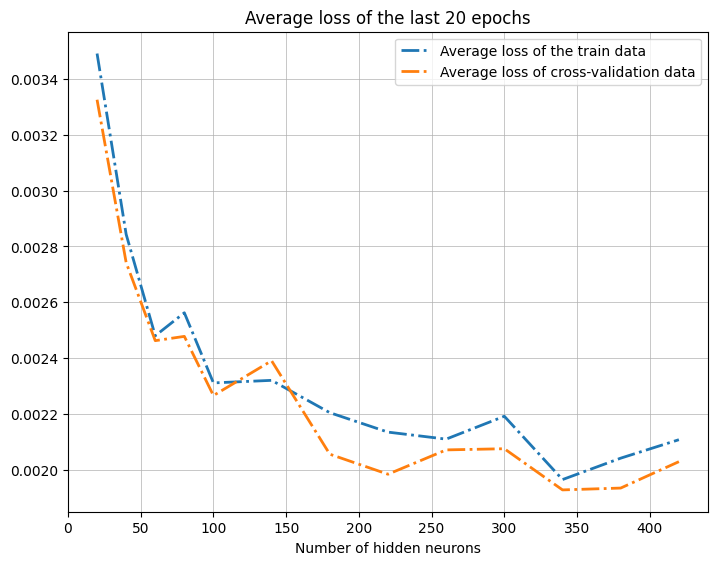

In [26]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = []
list_val = []
for val_loss in val_loss_total_arrays:
    avg = 0
    for val in val_loss[-10:]:
        avg = avg + (val/20.0)
    list_val.append(avg)

for train_loss in running_loss_total_arrays:
    avg = 0
    for train in train_loss[-10:]:
        avg = avg + (train/20.0)
    
    list_train.append(avg)


# >>> a=axes.get_xticks().tolist()
# >>> a[1]='change'
# >>> axes.set_xticklabels(a)

axes.plot(nums_neurons, list_train, ls='-.', lw=2, label='Average loss of the train data')
axes.plot(nums_neurons, list_val, ls='-.', lw=2, label='Average loss of cross-validation data')

axes.set_title(f'Average loss of the last 20 epochs')
axes.set_xlabel(f'Number of hidden neurons')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

### Segunda rodada de treinamento

In [ ]:
saved_state_dict = torch.load('mlp_weights.pth')

# Initialize the new model
extended_model = gMLP.GeneralizedMLP(input_size, output_size, 2)

# Copy the weights of the hidden_layer to hidden_layer1

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Terceira rodada de treinamento

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 3)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 2):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')


#### Quarta rodada de treinamento

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 4)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 3):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Quinta rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 5)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 4):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

#### Sexta rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 6)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 5):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Sétima rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 7)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 6):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Oitava rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 8)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 7):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

#### Nona rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 9)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 8):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Décima rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 10)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 9):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Prediction to R = 2 and gamma = 2

In [ ]:
# evaluate_model(extended_model, criterion, test_loader)
test_target.shape

In [ ]:
row_gamma_R_2

In [ ]:
row_gamma2_R_2 = row_gamma_R_2[(row_gamma_R_2['gamma'] > 2.0) & (row_gamma_R_2['gamma'] < 2.01)]

In [ ]:
row_gamma2_R_2

In [ ]:
inputs_row_gamma2_R_2 = row_gamma2_R_2.drop(columns=['gamma', 'R'])
inputs_row_gamma2_R_2 = inputs_row_gamma2_R_2.to_numpy()

In [ ]:
inputs_row_gamma2_R_2.shape

In [ ]:
test_r2_gamma2 = np.array([[2.0], [2.0]]).transpose()

In [ ]:
test_r2_gamma2.shape

In [ ]:
inputs_tensor_row_gamma2_R_2 = torch.tensor(inputs_row_gamma2_R_2, dtype=torch.float32)
target_test_r2_gamma2 = torch.tensor(test_r2_gamma2, dtype=torch.float32)

In [ ]:
test_r2_gamma2_dataset = torch.utils.data.TensorDataset(inputs_tensor_row_gamma2_R_2, target_test_r2_gamma2)
test_r2_gamma2_loader = torch.utils.data.DataLoader(test_r2_gamma2_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs = gMLP.evaluate_model(extended_model, criterion, test_r2_gamma2_loader)
outputs

In [ ]:
predicted = outputs.squeeze().tolist()
predicted_gamma_R = np.array(predicted)

In [ ]:
print('Considerando os dados para R = 2.0 e gamma = 2.0')
print('Os valores obtidos foram: ')
print('gamma: ', predicted_gamma_R[0])
print('R: ', predicted_gamma_R[1])
print('Erro quadrático médio: ', 0.00016762154700700194)

In [ ]:
gamma = predicted_gamma_R[0]
r = predicted_gamma_R[1]

cross_section = generateData.circularBarrierCrossSection(gamma, r, -20, 20, 0.02, 3.0, 596)

In [ ]:
cross_section

In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array[3], ls='-', label=f"True value")
axes.plot(k, cross_section, ls='-', label=f"Predicted value")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [ ]:
import matplotlib

u = np.linspace(0, 2 * np.pi, 100)

x_real, y_real = 2.0 * np.cos(u), 2.0 * np.sin(u)
x_predicted, y_predicted = r * np.cos(u), r * np.sin(u)

In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(x_real, y_real, ls='-', lw=1.0, label=f"True value")
axes.plot(x_predicted, y_predicted, ls='-', lw=1.0, label=f"Predicted value")
axes.set_title(f'Barrier')
axes.set_xlabel(f'x')
axes.set_xlabel(f'y')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [ ]:
input_size = 603
output_size = 2
rule_1 = max(input_size, output_size)
rule_2 = int(2/3 * input_size + output_size)
rule_3 = min(2 * input_size - 1, input_size + input_size // 3)
hidden_neurons = min(rule_1, rule_2, rule_3)

hidden_neurons